In [18]:
#necessary libraries
import numpy as np
import pandas as pd 

import requests


print("pandas version: "+str(pd.__version__)) #pandas version
print("numpy version: "+str(np.__version__)) #numpy version
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pandas version: 0.23.4
numpy version: 1.15.4


In [19]:
#reading dataset from the url

weather_df = pd.read_csv('testset.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')




In [20]:
#selecting columns important for time series prediction and renaming them(feature engineering)

weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})

weather_df.index = pd.to_datetime(weather_df.index)#needs to be converted to datetime to perform scaling during time series analysis.
print(f'dataset shape (rows, columns) - {weather_df.shape}')

dataset shape (rows, columns) - (100990, 3)


In [21]:
# will fill with previous valid value(data cleaning)
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()


#removing outliers as max temperature is 90 and max humidity is 243
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]


weather_df.describe()

,humidity,temprature
count,100983.000000,100983.000000
mean,57.955309,25.436361
std,23.805467,8.482944
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,100.000000,47.000000


In [22]:
#splitting data into training and test data

train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

In [23]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [32]:
# Augmented Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])
    

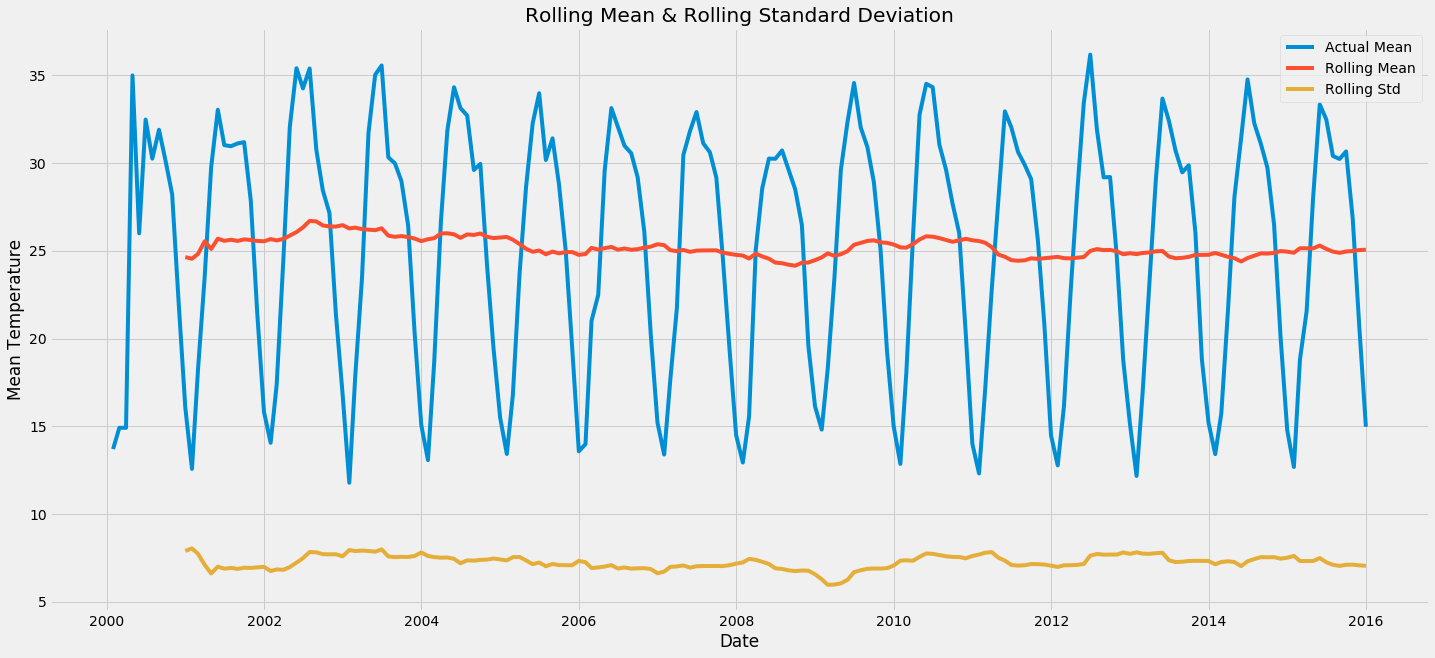

Test statistic:  -2.1269952502980254
Critical Values: {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}


In [33]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature) #test statistic must be less than critical values


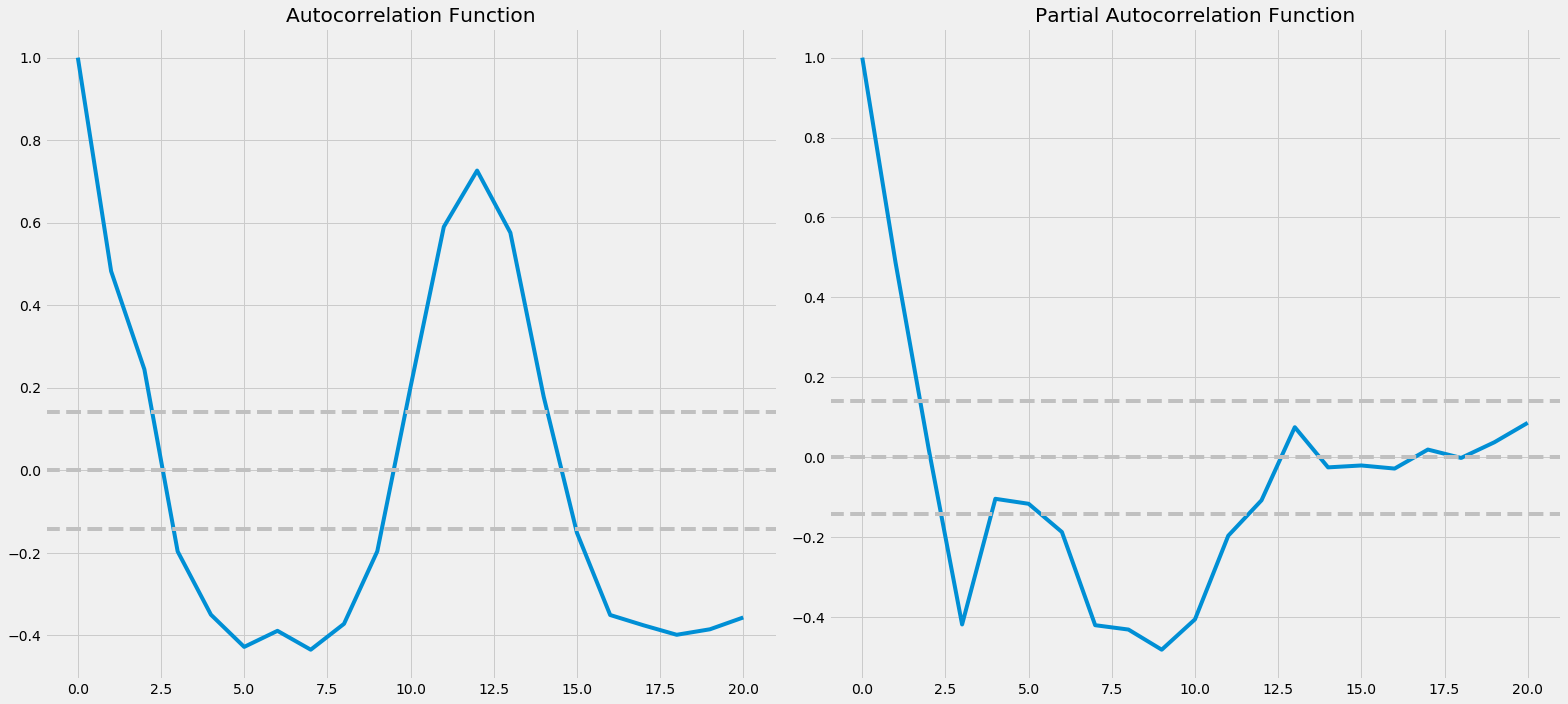

In [42]:
#plotting pacf and acf to find p and q values of ARIMA model

acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')#upper confidence level
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')#lower confidence level
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')#upper confidence level
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')#lower confidence level
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [43]:
#fitting the ARIMA model p=2,d=0,q=0
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood                -454.355
Method:                       css-mle   S.D. of innovations              2.552
Date:                Wed, 03 Jul 2019   AIC                            920.709
Time:                        01:36:51   BIC                            940.254
Sample:                             0   HQIC                           928.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1917      0.119    211.045      0.000      24.958      25.426
ar.L1.y        1.6785      0.024     69.835      0.000       1.631       1.726
ar.L2.y       -0.9519      0.023    -41.164      0.0

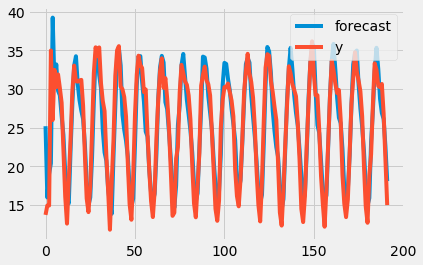

In [53]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

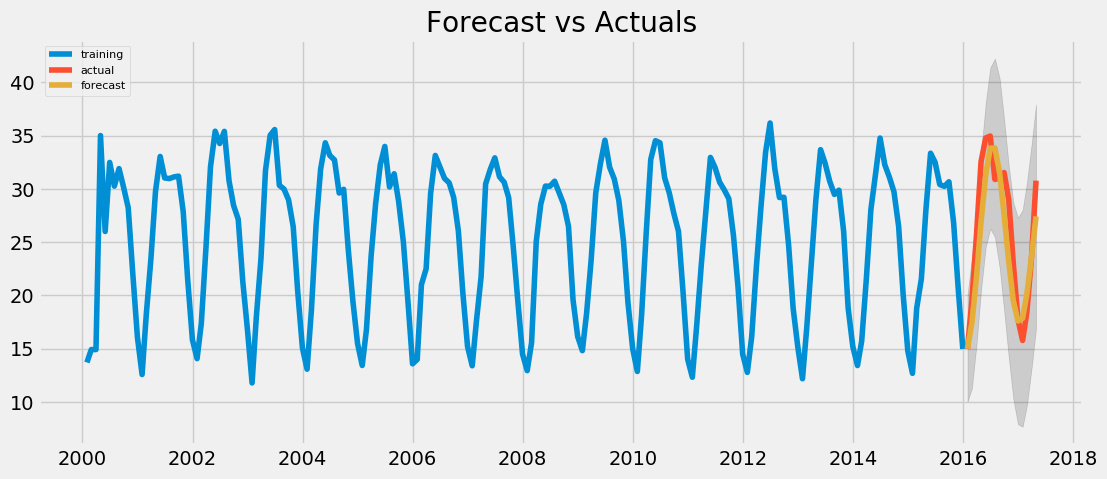

In [57]:
# # Forecast
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()